In [ ]:
# 快速修復版本 - 專門處理.au格式文件
import os
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle

class GTZANProcessor_Fixed:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
                      'jazz', 'metal', 'pop', 'reggae', 'rock']
        self.sample_rate = 22050
        self.duration = 30
        self.n_mels = 128

    def find_correct_path(self):
        """找到正確的音頻文件路徑"""
        # 基於你的輸出，正確路徑應該是
        correct_path = os.path.join(self.dataset_path, "gtzan-genre-collection", "genres")

        if os.path.exists(correct_path):
            print(f"✅ 找到正確的音頻目錄: {correct_path}")
            return correct_path

        # 備選路徑
        alternatives = [
            os.path.join(self.dataset_path, "genres"),
            self.dataset_path
        ]

        for path in alternatives:
            if os.path.exists(path):
                subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
                if any(genre in subdirs for genre in self.genres):
                    print(f"✅ 找到替代音頻目錄: {path}")
                    return path

        print(f"❌ 找不到音頻目錄，使用原始路徑: {self.dataset_path}")
        return self.dataset_path

    def load_and_process(self):
        """加載和處理音頻文件"""
        audio_path = self.find_correct_path()

        audio_data = []
        labels = []

        print("=== 開始加載.au格式音頻文件 ===")

        for genre in tqdm(self.genres, desc="處理音樂類型"):
            genre_path = os.path.join(audio_path, genre)

            if not os.path.exists(genre_path):
                print(f"❌ 跳過 {genre}: 目錄不存在")
                continue

            # 查找.au文件
            audio_files = [f for f in os.listdir(genre_path) if f.endswith('.au')]
            print(f"📁 {genre}: 找到 {len(audio_files)} 個.au文件")

            if len(audio_files) == 0:
                print(f"⚠️  {genre}: 沒有找到音頻文件")
                continue

            # 處理每個文件
            for file in tqdm(audio_files[:10], desc=f"加載 {genre}", leave=False):  # 先測試10個文件
                try:
                    file_path = os.path.join(genre_path, file)

                    # librosa可以直接讀取.au格式
                    audio, sr = librosa.load(file_path, sr=self.sample_rate, duration=self.duration)

                    # 確保長度一致
                    target_length = self.sample_rate * self.duration
                    if len(audio) < target_length:
                        audio = np.pad(audio, (0, target_length - len(audio)))
                    else:
                        audio = audio[:target_length]

                    # 轉換為Mel頻譜圖
                    mel_spec = librosa.feature.melspectrogram(
                        y=audio, sr=self.sample_rate, n_mels=self.n_mels
                    )
                    mel_spec_db = librosa.power_to_db(mel_spec)

                    # 標準化
                    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
                    mel_spec_norm = 2 * mel_spec_norm - 1

                    audio_data.append(mel_spec_norm)
                    labels.append(genre)

                except Exception as e:
                    print(f"❌ 處理文件失敗 {file}: {e}")

        if len(audio_data) == 0:
            print("❌ 沒有成功處理任何文件！")
            return None

        # 轉換為numpy數組
        spectrograms = np.array(audio_data)
        labels_array = np.array(labels)

        print(f"\n✅ 成功處理 {len(spectrograms)} 個音頻文件")
        print(f"📊 頻譜圖形狀: {spectrograms.shape}")

        # 統計各類型數量
        unique_labels, counts = np.unique(labels_array, return_counts=True)
        print("\n📈 各類型統計:")
        for label, count in zip(unique_labels, counts):
            print(f"  {label}: {count} 個文件")

        return {
            'spectrograms': spectrograms,
            'labels': labels_array,
            'genres': self.genres
        }

# 測試運行
if __name__ == "__main__":
    # 使用你的數據集路徑
    path = "/kaggle/input/gtzan-genre-collection"  # 替換為你的實際路徑

    processor = GTZANProcessor_Fixed(path)
    result = processor.load_and_process()

    if result is not None:
        print(f"\n🎉 數據處理成功！")
        print(f"頻譜圖數據形狀: {result['spectrograms'].shape}")
        print(f"標籤數量: {len(result['labels'])}")

        # 保存處理結果
        with open('gtzan_processed_quick.pkl', 'wb') as f:
            pickle.dump(result, f)
        print("💾 數據已保存到 gtzan_processed_quick.pkl")
    else:
        print("❌ 數據處理失敗")

✅ 找到替代音頻目錄: /kaggle/input/gtzan-genre-collection/genres
=== 開始加載.au格式音頻文件 ===


處理音樂類型:   0%|          | 0/10 [00:00<?, ?it/s]

📁 blues: 找到 100 個.au文件



處理音樂類型:  10%|█         | 1/10 [00:20<03:06, 20.77s/it]

📁 classical: 找到 100 個.au文件



處理音樂類型:  20%|██        | 2/10 [00:21<01:12,  9.07s/it]

📁 country: 找到 100 個.au文件



處理音樂類型:  30%|███       | 3/10 [00:22<00:37,  5.30s/it]

📁 disco: 找到 100 個.au文件



處理音樂類型:  40%|████      | 4/10 [00:23<00:22,  3.74s/it]

📁 hiphop: 找到 100 個.au文件



處理音樂類型:  50%|█████     | 5/10 [00:25<00:14,  3.00s/it]

📁 jazz: 找到 100 個.au文件



處理音樂類型:  60%|██████    | 6/10 [00:26<00:09,  2.31s/it]

📁 metal: 找到 100 個.au文件



處理音樂類型:  70%|███████   | 7/10 [00:27<00:05,  1.83s/it]

📁 pop: 找到 100 個.au文件



處理音樂類型:  80%|████████  | 8/10 [00:28<00:03,  1.52s/it]

📁 reggae: 找到 100 個.au文件



處理音樂類型:  90%|█████████ | 9/10 [00:29<00:01,  1.32s/it]

📁 rock: 找到 100 個.au文件



處理音樂類型: 100%|██████████| 10/10 [00:29<00:00,  2.99s/it]



✅ 成功處理 100 個音頻文件
📊 頻譜圖形狀: (100, 128, 1292)

📈 各類型統計:
  blues: 10 個文件
  classical: 10 個文件
  country: 10 個文件
  disco: 10 個文件
  hiphop: 10 個文件
  jazz: 10 個文件
  metal: 10 個文件
  pop: 10 個文件
  reggae: 10 個文件
  rock: 10 個文件

🎉 數據處理成功！
頻譜圖數據形狀: (100, 128, 1292)
標籤數量: 100
💾 數據已保存到 gtzan_processed_quick.pkl


Path to dataset files: /kaggle/input/gtzan-genre-collection
=== 開始處理GTZAN數據集 ===
=== 數據集結構探索 ===
數據集路徑: /kaggle/input/gtzan-genre-collection
gtzan-genre-collection/
  genres/
    disco/
      disco.00031.au
      disco.00091.au
      disco.00043.au
      disco.00014.au
      disco.00066.au
      ... 還有 95 個文件
    metal/
      metal.00057.au
      metal.00024.au
      metal.00071.au
      metal.00059.au
      metal.00038.au
      ... 還有 95 個文件
    reggae/
      reggae.00093.au
      reggae.00090.au
      reggae.00088.au
      reggae.00011.au
      reggae.00032.au
      ... 還有 95 個文件
    blues/
      blues.00007.au
      blues.00053.au
      blues.00005.au
      blues.00025.au
      blues.00070.au
      ... 還有 95 個文件
    rock/
      rock.00077.au
      rock.00093.au
      rock.00008.au
      rock.00033.au
      rock.00069.au
      ... 還有 95 個文件
    classical/
      classical.00052.au
      classical.00045.au
      classical.00014.au
      classical.00092.au
      classical.00083.au
     

處理音樂類型:   0%|          | 0/10 [00:00<?, ?it/s]

blues: 找到 100 個文件



處理音樂類型:  10%|█         | 1/10 [00:02<00:23,  2.65s/it]

classical: 找到 100 個文件



處理音樂類型:  20%|██        | 2/10 [00:05<00:21,  2.68s/it]

country: 找到 100 個文件



處理音樂類型:  30%|███       | 3/10 [00:08<00:18,  2.70s/it]

disco: 找到 100 個文件



處理音樂類型:  40%|████      | 4/10 [00:10<00:16,  2.67s/it]

hiphop: 找到 100 個文件



處理音樂類型:  50%|█████     | 5/10 [00:13<00:13,  2.68s/it]

jazz: 找到 100 個文件



處理音樂類型:  60%|██████    | 6/10 [00:16<00:10,  2.66s/it]

metal: 找到 100 個文件



處理音樂類型:  70%|███████   | 7/10 [00:18<00:08,  2.69s/it]

pop: 找到 100 個文件



處理音樂類型:  80%|████████  | 8/10 [00:21<00:05,  2.70s/it]

reggae: 找到 100 個文件



處理音樂類型:  90%|█████████ | 9/10 [00:24<00:02,  2.69s/it]

rock: 找到 100 個文件



處理音樂類型: 100%|██████████| 10/10 [00:26<00:00,  2.69s/it]



成功加載 1000 個音頻文件

=== 轉換為Mel頻譜圖 ===


轉換頻譜圖: 100%|██████████| 1000/1000 [01:09<00:00, 14.30it/s]



=== 數據集統計信息 ===
總音頻文件數: 1000
頻譜圖形狀: (1000, 128, 1292)
頻譜圖範圍: [-1.000, 1.000]

各音樂類型統計:
  blues: 100 個文件
  classical: 100 個文件
  country: 100 個文件
  disco: 100 個文件
  hiphop: 100 個文件
  jazz: 100 個文件
  metal: 100 個文件
  pop: 100 個文件
  reggae: 100 個文件
  rock: 100 個文件

處理後的數據已保存到: gtzan_processed_data.pkl

PyTorch數據集準備完成:
  數據集大小: 1000
  頻譜圖形狀: torch.Size([1000, 1, 128, 1292])
  批次數: 32


<ipython-input-3-27fdd12b1b77>:227: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-27fdd12b1b77>:227: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-27fdd12b1b77>:227: UserWarning: Glyph 24128 (\N{CJK UNIFIED IDEOGRAPH-5E40}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-27fdd12b1b77>:227: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-27fdd12b1b77>:227: UserWarning: Glyph 24118 (\N{CJK UNIFIED IDEOGRAPH-5E36}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-27fdd12b1b77>:227: UserWarning: Glyph 27171 (\N{CJK UNIFIED IDEOGRAPH-6A23}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-27fdd12b1b77>:227: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from

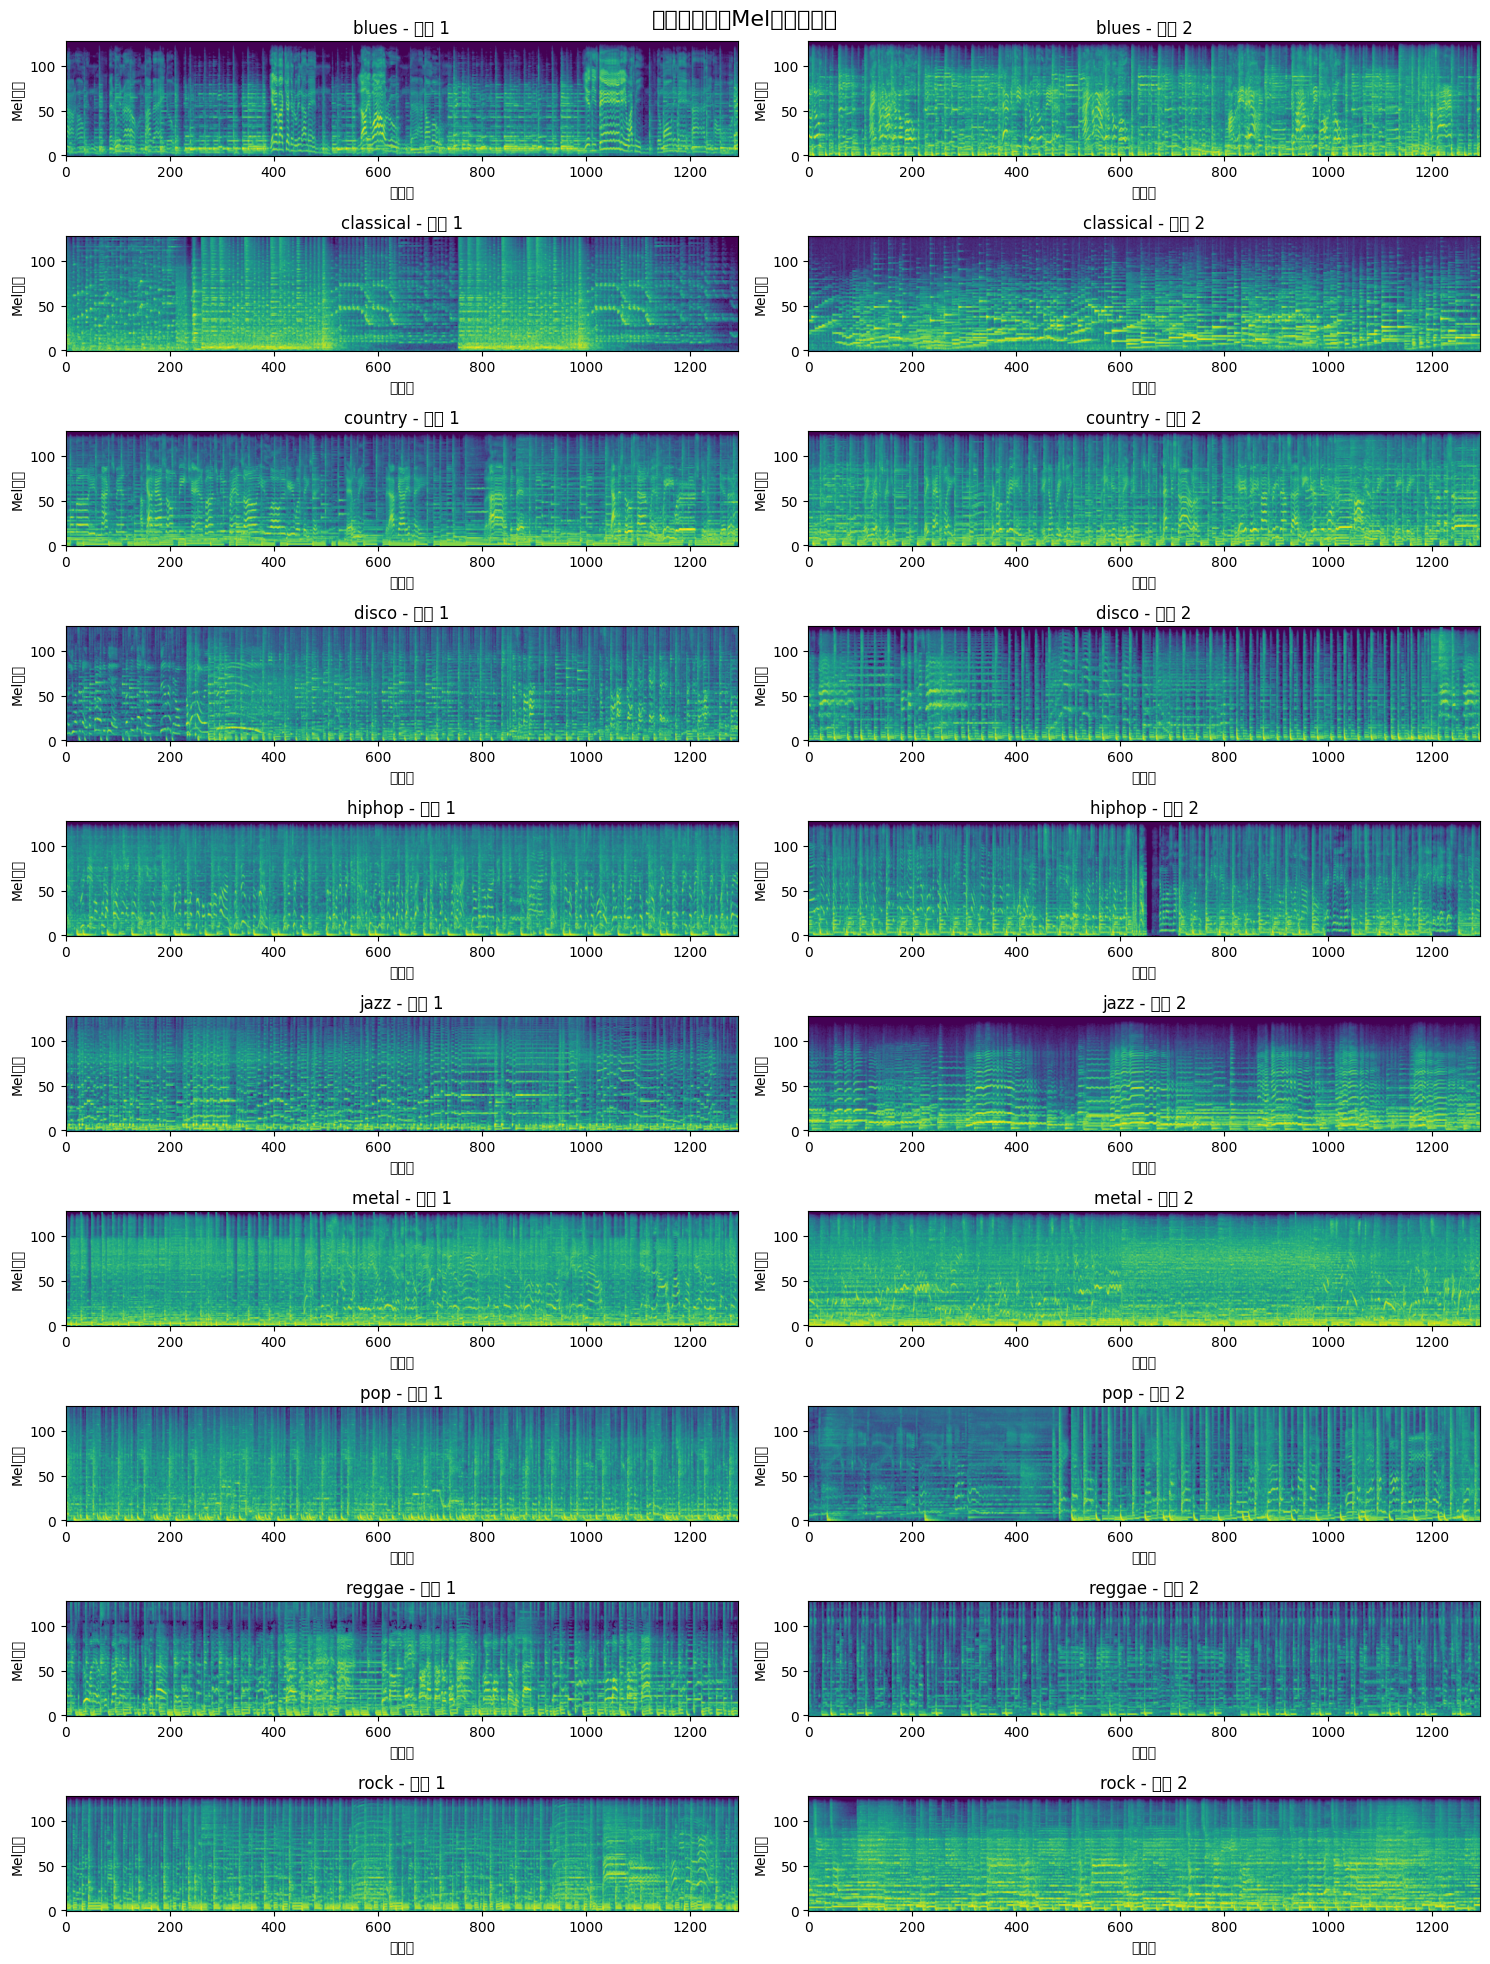

頻譜圖樣本已保存到: gtzan_spectrogram_samples.png

✅ 數據預處理完成！可以開始訓練模型了。


In [ ]:
import kagglehub
import os
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm import tqdm
import pickle

# Download latest version
path = kagglehub.dataset_download("carlthome/gtzan-genre-collection")
print("Path to dataset files:", path)

class GTZANDatasetProcessor:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
                      'jazz', 'metal', 'pop', 'reggae', 'rock']
        self.sample_rate = 22050
        self.duration = 30  # 30 seconds
        self.n_mels = 128
        self.n_fft = 2048
        self.hop_length = 512

    def explore_dataset_structure(self):
        """探索數據集結構"""
        print("=== 數據集結構探索 ===")
        print(f"數據集路徑: {self.dataset_path}")

        # 查看目錄結構
        for root, dirs, files in os.walk(self.dataset_path):
            level = root.replace(self.dataset_path, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 2 * (level + 1)
            for file in files[:5]:  # 只顯示前5個文件
                print(f"{subindent}{file}")
            if len(files) > 5:
                print(f"{subindent}... 還有 {len(files)-5} 個文件")

    def load_audio_files(self):
        """加載所有音頻文件"""
        audio_data = []
        labels = []
        file_info = []

        print("=== 開始加載音頻文件 ===")

        # 查找實際的音頻文件路徑
        audio_path = self.find_audio_directory()

        for genre in tqdm(self.genres, desc="處理音樂類型"):
            genre_path = os.path.join(audio_path, genre)

            if not os.path.exists(genre_path):
                print(f"警告: 找不到 {genre} 目錄，跳過...")
                continue

            genre_files = [f for f in os.listdir(genre_path) if f.endswith(('.wav', '.au'))]  # 支持.au格式
            print(f"{genre}: 找到 {len(genre_files)} 個文件")

            for file in tqdm(genre_files, desc=f"加載 {genre}", leave=False):
                try:
                    file_path = os.path.join(genre_path, file)

                    # 加載音頻
                    audio, sr = librosa.load(file_path, sr=self.sample_rate, duration=self.duration)

                    # 確保音頻長度一致
                    if len(audio) < self.sample_rate * self.duration:
                        # 如果音頻太短，用零填充
                        audio = np.pad(audio, (0, self.sample_rate * self.duration - len(audio)))
                    else:
                        # 如果音頻太長，截斷
                        audio = audio[:self.sample_rate * self.duration]

                    audio_data.append(audio)
                    labels.append(genre)
                    file_info.append({
                        'file': file,
                        'genre': genre,
                        'path': file_path,
                        'duration': len(audio) / sr
                    })

                except Exception as e:
                    print(f"加載文件出錯 {file}: {e}")

        print(f"\n成功加載 {len(audio_data)} 個音頻文件")
        return np.array(audio_data), np.array(labels), file_info

    def find_audio_directory(self):
        """查找音頻文件的實際目錄"""
        # 可能的路徑
        possible_paths = [
            os.path.join(self.dataset_path, "Data", "genres_original"),
            os.path.join(self.dataset_path, "genres_original"),
            os.path.join(self.dataset_path, "data", "genres_original"),
            os.path.join(self.dataset_path, "gtzan-genre-collection", "genres"),  # 新增
            os.path.join(self.dataset_path, "genres"),  # 新增
            self.dataset_path
        ]

        for path in possible_paths:
            if os.path.exists(path):
                # 檢查是否包含類型目錄
                subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
                if any(genre in subdirs for genre in self.genres):
                    print(f"找到音頻目錄: {path}")
                    return path

        # 如果找不到，返回原始路徑
        print(f"使用默認路徑: {self.dataset_path}")
        return self.dataset_path

    def audio_to_mel_spectrogram(self, audio):
        """將音頻轉換為Mel頻譜圖"""
        # 計算Mel頻譜圖
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels
        )

        # 轉換為dB刻度
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # 標準化到[-1, 1]
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())
        mel_spec_norm = 2 * mel_spec_norm - 1

        return mel_spec_norm

    def process_dataset(self, save_processed=True):
        """處理整個數據集"""
        print("=== 開始處理GTZAN數據集 ===")

        # 1. 探索數據集結構
        self.explore_dataset_structure()

        # 2. 加載音頻文件
        audio_data, labels, file_info = self.load_audio_files()

        if len(audio_data) == 0:
            print("錯誤: 沒有成功加載任何音頻文件！")
            return None

        # 3. 轉換為Mel頻譜圖
        print("\n=== 轉換為Mel頻譜圖 ===")
        spectrograms = []

        for audio in tqdm(audio_data, desc="轉換頻譜圖"):
            mel_spec = self.audio_to_mel_spectrogram(audio)
            spectrograms.append(mel_spec)

        spectrograms = np.array(spectrograms)

        # 4. 編碼標籤
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)

        # 5. 數據統計
        self.print_dataset_stats(spectrograms, labels, file_info)

        # 6. 保存處理後的數據
        processed_data = {
            'spectrograms': spectrograms,
            'labels': encoded_labels,
            'label_names': labels,
            'label_encoder': label_encoder,
            'file_info': file_info,
            'config': {
                'sample_rate': self.sample_rate,
                'n_mels': self.n_mels,
                'n_fft': self.n_fft,
                'hop_length': self.hop_length
            }
        }

        if save_processed:
            save_path = 'gtzan_processed_data.pkl'
            with open(save_path, 'wb') as f:
                pickle.dump(processed_data, f)
            print(f"\n處理後的數據已保存到: {save_path}")

        return processed_data

    def print_dataset_stats(self, spectrograms, labels, file_info):
        """打印數據集統計信息"""
        print("\n=== 數據集統計信息 ===")
        print(f"總音頻文件數: {len(spectrograms)}")
        print(f"頻譜圖形狀: {spectrograms.shape}")
        print(f"頻譜圖範圍: [{spectrograms.min():.3f}, {spectrograms.max():.3f}]")

        # 各類型統計
        unique_labels, counts = np.unique(labels, return_counts=True)
        print("\n各音樂類型統計:")
        for label, count in zip(unique_labels, counts):
            print(f"  {label}: {count} 個文件")

    def visualize_samples(self, processed_data, n_samples=2):
        """可視化每種類型的樣本頻譜圖"""
        spectrograms = processed_data['spectrograms']
        labels = processed_data['label_names']

        fig, axes = plt.subplots(len(self.genres), n_samples, figsize=(15, 20))
        fig.suptitle('各音樂類型的Mel頻譜圖樣本', fontsize=16)

        for i, genre in enumerate(self.genres):
            # 找到該類型的樣本索引
            genre_indices = [j for j, label in enumerate(labels) if label == genre]

            for j in range(min(n_samples, len(genre_indices))):
                idx = genre_indices[j]
                ax = axes[i, j] if n_samples > 1 else axes[i]

                im = ax.imshow(spectrograms[idx], aspect='auto', origin='lower', cmap='viridis')
                ax.set_title(f"{genre} - 樣本 {j+1}")
                ax.set_xlabel("時間幀")
                ax.set_ylabel("Mel頻帶")

        plt.tight_layout()
        plt.savefig('gtzan_spectrogram_samples.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("頻譜圖樣本已保存到: gtzan_spectrogram_samples.png")


class GTZANDataset(Dataset):
    """PyTorch數據集類"""
    def __init__(self, processed_data):
        self.spectrograms = torch.FloatTensor(processed_data['spectrograms'])
        self.labels = torch.LongTensor(processed_data['labels'])
        self.label_encoder = processed_data['label_encoder']

        # 添加通道維度 (B, C, H, W)
        self.spectrograms = self.spectrograms.unsqueeze(1)

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

    def get_genre_samples(self, genre_name, n_samples=5):
        """獲取特定類型的樣本"""
        genre_idx = list(self.label_encoder.classes_).index(genre_name)
        mask = self.labels == genre_idx
        indices = torch.where(mask)[0][:n_samples]
        return self.spectrograms[indices], self.labels[indices]


# 主要執行代碼
if __name__ == "__main__":
    # 初始化處理器
    processor = GTZANDatasetProcessor(path)

    # 處理數據集
    processed_data = processor.process_dataset()

    if processed_data is not None:
        # 創建PyTorch數據集
        dataset = GTZANDataset(processed_data)

        # 創建數據加載器
        dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

        print(f"\nPyTorch數據集準備完成:")
        print(f"  數據集大小: {len(dataset)}")
        print(f"  頻譜圖形狀: {dataset.spectrograms.shape}")
        print(f"  批次數: {len(dataloader)}")

        # 可視化樣本
        processor.visualize_samples(processed_data)

        print("\n✅ 數據預處理完成！可以開始訓練模型了。")
    else:
        print("❌ 數據處理失敗，請檢查數據集路徑和文件結構。")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import soundfile as sf
import os

class CausalConv1d(nn.Module):
    """因果卷積層 - 確保生成時不會看到未來的信息"""

    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                             padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv(x)
        # 移除右側的padding以保持因果性
        if self.padding > 0:
            x = x[:, :, :-self.padding]
        return x


class ResidualBlock(nn.Module):
    """WaveNet的核心殘差塊"""

    def __init__(self, residual_channels, gate_channels, skip_channels,
                 kernel_size, dilation, condition_channels=None):
        super(ResidualBlock, self).__init__()

        self.dilated_conv = CausalConv1d(residual_channels, gate_channels,
                                        kernel_size, dilation)

        # 條件輸入（如音樂風格）
        self.condition_channels = condition_channels
        if condition_channels:
            self.condition_conv = nn.Conv1d(condition_channels, gate_channels, 1)

        # 門控機制
        self.output_conv = nn.Conv1d(gate_channels // 2, residual_channels, 1)
        self.skip_conv = nn.Conv1d(gate_channels // 2, skip_channels, 1)

    def forward(self, x, condition=None):
        # 殘差連接的輸入
        residual = x

        # 膨脹卷積
        x = self.dilated_conv(x)

        # 添加條件信息
        if condition is not None and self.condition_channels:
            condition = self.condition_conv(condition)
            x = x + condition

        # 門控激活：tanh * sigmoid
        tanh_out, sigmoid_out = torch.chunk(x, 2, dim=1)
        x = torch.tanh(tanh_out) * torch.sigmoid(sigmoid_out)

        # 輸出分支
        skip = self.skip_conv(x)
        output = self.output_conv(x)

        return (output + residual), skip


class WaveNet(nn.Module):
    """WaveNet音樂生成模型"""

    def __init__(self,
                 layers=10,           # 每個stack的層數
                 stacks=3,            # stack數量
                 residual_channels=64, # 殘差通道數
                 gate_channels=128,    # 門控通道數
                 skip_channels=64,     # 跳躍連接通道數
                 output_channels=256,  # 輸出通道數（量化級別）
                 kernel_size=2,        # 卷積核大小
                 condition_channels=None):  # 條件通道數

        super(WaveNet, self).__init__()

        self.layers = layers
        self.stacks = stacks
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.output_channels = output_channels

        # 計算感受野大小
        self.receptive_field = self.calculate_receptive_field()

        # 輸入卷積層（將one-hot編碼的音頻映射到殘差通道）
        self.start_conv = CausalConv1d(output_channels, residual_channels, 1)

        # 殘差塊
        self.residual_blocks = nn.ModuleList()
        for stack in range(stacks):
            for layer in range(layers):
                dilation = 2 ** layer
                block = ResidualBlock(
                    residual_channels=residual_channels,
                    gate_channels=gate_channels,
                    skip_channels=skip_channels,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    condition_channels=condition_channels
                )
                self.residual_blocks.append(block)

        # 最終輸出層
        self.end_conv1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.end_conv2 = nn.Conv1d(skip_channels, output_channels, 1)

    def calculate_receptive_field(self):
        """計算模型的感受野大小"""
        receptive_field = 1
        for stack in range(self.stacks):
            for layer in range(self.layers):
                dilation = 2 ** layer
                receptive_field += dilation
        return receptive_field

    def forward(self, x, condition=None):
        # x shape: (batch_size, quantization_levels, seq_len) - one-hot編碼
        # condition shape: (batch_size, condition_channels, seq_len) 如果有的話

        # 輸入卷積
        x = self.start_conv(x)

        # 累積跳躍連接
        skip_connections = []

        # 通過所有殘差塊
        for block in self.residual_blocks:
            x, skip = block(x, condition)
            skip_connections.append(skip)

        # 合併跳躍連接
        skip_sum = torch.stack(skip_connections, dim=0).sum(dim=0)

        # 最終輸出層
        x = F.relu(skip_sum)
        x = F.relu(self.end_conv1(x))
        x = self.end_conv2(x)

        return x


class MusicWaveNetDataset(Dataset):
    """音樂生成的數據集類"""

    def __init__(self, processed_data, sequence_length=8000, quantization_levels=256):
        self.sequence_length = sequence_length
        self.quantization_levels = quantization_levels

        # 從處理後的數據中獲取原始音頻
        self.audio_data = []
        self.genre_labels = []

        # 重新加載原始音頻文件用於生成
        self.load_audio_for_generation(processed_data)

    def load_audio_for_generation(self, processed_data):
        """重新加載原始音頻數據用於生成"""
        print("為WaveNet加載原始音頻數據...")

        file_info = processed_data['file_info']
        label_encoder = processed_data['label_encoder']

        # 限制文件數量以避免內存問題
        max_files = min(50, len(file_info))

        for info in tqdm(file_info[:max_files], desc="加載音頻"):
            try:
                # 加載原始音頻，縮短長度以節省內存
                audio, sr = librosa.load(info['path'], sr=22050, duration=10)  # 只用10秒

                # 量化音頻到指定級別
                audio_quantized = self.quantize_audio(audio)

                # 分割成序列
                sequences = self.create_sequences(audio_quantized)

                # 獲取類型標籤
                genre = info['genre']
                genre_idx = label_encoder.transform([genre])[0]

                for seq in sequences:
                    self.audio_data.append(seq)
                    self.genre_labels.append(genre_idx)

            except Exception as e:
                print(f"處理文件出錯 {info['file']}: {e}")

        print(f"共生成 {len(self.audio_data)} 個訓練序列")

    def quantize_audio(self, audio):
        """將音頻量化到指定級別"""
        # 歸一化到[-1, 1]
        audio = np.clip(audio, -1, 1)

        # 量化到[0, quantization_levels-1]
        audio_quantized = np.round((audio + 1) * (self.quantization_levels - 1) / 2)
        audio_quantized = audio_quantized.astype(np.int64)

        return audio_quantized

    def create_sequences(self, audio_quantized):
        """將音頻分割成訓練序列"""
        sequences = []

        # 滑動窗口創建序列
        step_size = max(1, self.sequence_length // 4)  # 增加重疊以獲得更多數據
        for i in range(0, len(audio_quantized) - self.sequence_length, step_size):
            seq = audio_quantized[i:i + self.sequence_length]
            if len(seq) == self.sequence_length:
                sequences.append(seq)

        return sequences

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        sequence = self.audio_data[idx]
        genre = self.genre_labels[idx]

        # 輸入和目標（目標是輸入向右偏移一位）
        x = torch.LongTensor(sequence[:-1])
        y = torch.LongTensor(sequence[1:])

        return x, y, genre


class MusicGenerator:
    """音樂生成器"""

    def __init__(self, model, quantization_levels=256, sample_rate=22050):
        self.model = model
        self.quantization_levels = quantization_levels
        self.sample_rate = sample_rate
        self.device = next(model.parameters()).device

    def generate(self, length=22050, temperature=1.0, condition=None, seed=None):
        """生成音頻序列"""
        self.model.eval()

        if seed is not None:
            torch.manual_seed(seed)

        # 初始化序列
        generated = torch.zeros(1, 1, self.model.receptive_field,
                              dtype=torch.long, device=self.device)

        # 如果有條件輸入，準備條件張量
        if condition is not None:
            condition_tensor = torch.zeros(1, condition, length + self.model.receptive_field,
                                         device=self.device)
        else:
            condition_tensor = None

        generated_samples = []

        print(f"生成 {length} 個樣本...")
        with torch.no_grad():
            for i in tqdm(range(length)):
                # 準備輸入
                x = self.one_hot_encode(generated)  # (batch, channels, time)

                # 準備條件（如果有）
                cond = None
                if condition_tensor is not None:
                    cond = condition_tensor[:, :, :x.size(2)]

                # 前向傳播
                logits = self.model(x, cond)

                # 獲取最後一個時間步的預測
                logits = logits[:, :, -1] / temperature

                # 采樣
                probs = F.softmax(logits, dim=1)
                sample = torch.multinomial(probs, 1).squeeze()

                # 添加到生成序列
                generated_samples.append(sample.item())

                # 更新輸入序列
                next_sample = sample.unsqueeze(0).unsqueeze(0).unsqueeze(0)
                generated = torch.cat([generated[:, :, 1:], next_sample], dim=2)

        # 反量化到音頻
        audio = self.dequantize_audio(generated_samples)
        return audio

    def one_hot_encode(self, x):
        """將量化的音頻轉換為one-hot編碼"""
        # x shape: (batch, 1, time)
        batch_size, _, time_steps = x.size()

        # 創建one-hot編碼
        one_hot = torch.zeros(batch_size, self.quantization_levels, time_steps,
                             device=x.device)
        one_hot.scatter_(1, x, 1)

        return one_hot

    def dequantize_audio(self, quantized_samples):
        """將量化的樣本轉換回音頻"""
        # 從[0, quantization_levels-1]轉換到[-1, 1]
        audio = np.array(quantized_samples, dtype=np.float32)
        audio = (audio * 2 / (self.quantization_levels - 1)) - 1

        return audio

    def save_audio(self, audio, filename, sample_rate=None):
        """保存生成的音頻"""
        if sample_rate is None:
            sample_rate = self.sample_rate

        sf.write(filename, audio, sample_rate)
        print(f"音頻已保存到: {filename}")


class WaveNetTrainer:
    """WaveNet訓練器"""

    def __init__(self, model, device=None):
        self.model = model
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None

        print(f"WaveNet訓練器初始化完成")
        print(f"設備: {self.device}")
        print(f"模型參數數量: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"感受野大小: {self.model.receptive_field}")

    def setup_training(self, learning_rate=0.001, weight_decay=1e-5):
        """設置訓練參數"""
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

    def train_epoch(self, train_loader):
        """訓練一個epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc='Training WaveNet')
        for batch_idx, (x, y, genre) in enumerate(pbar):
            x, y = x.to(self.device), y.to(self.device)

            # 轉換為one-hot編碼
            x_onehot = self.one_hot_encode(x)

            self.optimizer.zero_grad()

            # 前向傳播
            logits = self.model(x_onehot)

            # 重塑輸出用於損失計算
            logits = logits.permute(0, 2, 1).contiguous()
            logits = logits.view(-1, logits.size(-1))
            y = y.view(-1)

            # 計算損失
            loss = self.criterion(logits, y)
            loss.backward()

            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            # 統計
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        return total_loss / len(train_loader), 100. * correct / total

    def one_hot_encode(self, x):
        """將量化的音頻轉換為one-hot編碼"""
        batch_size, seq_len = x.size()

        # 創建one-hot編碼
        one_hot = torch.zeros(batch_size, self.model.output_channels, seq_len,
                             device=x.device)
        one_hot.scatter_(1, x.unsqueeze(1), 1)

        return one_hot

    def train(self, train_loader, epochs=10, save_interval=5):
        """完整訓練流程"""
        if self.optimizer is None:
            self.setup_training()

        train_losses = []
        train_accs = []

        print(f"\n開始訓練WaveNet {epochs} 個epochs...")

        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')

            # 訓練
            train_loss, train_acc = self.train_epoch(train_loader)

            train_losses.append(train_loss)
            train_accs.append(train_acc)

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

            # 定期保存模型
            if (epoch + 1) % save_interval == 0:
                torch.save(self.model.state_dict(), f'wavenet_epoch_{epoch+1}.pth')
                print(f'模型已保存: wavenet_epoch_{epoch+1}.pth')

        # 保存最終模型
        torch.save(self.model.state_dict(), 'wavenet_final.pth')

        return {
            'train_losses': train_losses,
            'train_accs': train_accs
        }


# 使用示例
def main():
    # 載入處理後的數據
    print("載入數據...")
    with open('gtzan_processed_data.pkl', 'rb') as f:
        processed_data = pickle.load(f)

    # 創建WaveNet數據集 - 使用較小的序列長度
    dataset = MusicWaveNetDataset(processed_data, sequence_length=2000)

    # 創建數據加載器 - 減小批次大小
    train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

    # 創建WaveNet模型 - 使用較小的參數
    model = WaveNet(
        layers=6,              # 減少層數
        stacks=2,              # 減少堆疊數
        residual_channels=32,  # 減少通道數
        gate_channels=64,      # 減少通道數
        skip_channels=32,      # 減少通道數
        output_channels=256,
        kernel_size=2
    )

    print(f"數據集大小: {len(dataset)}")
    print(f"批次數: {len(train_loader)}")

    # 訓練模型
    trainer = WaveNetTrainer(model)
    history = trainer.train(train_loader, epochs=5)  # 減少訓練輪數

    # 生成音樂
    print("\n開始生成音樂...")
    generator = MusicGenerator(model)

    # 生成2秒的音頻
    generated_audio = generator.generate(length=22050 * 2, temperature=0.8)

    # 保存生成的音頻
    generator.save_audio(generated_audio, 'generated_music.wav')

    print("✅ 音樂生成完成！")


if __name__ == "__main__":
    main()

載入數據...
為WaveNet加載原始音頻數據...


加載音頻: 100%|██████████| 50/50 [00:00<00:00, 94.67it/s]


共生成 21850 個訓練序列
數據集大小: 21850
批次數: 10925
WaveNet訓練器初始化完成
設備: cpu
模型參數數量: 92,992
感受野大小: 127

開始訓練WaveNet 5 個epochs...

Epoch 1/5


Training WaveNet:  16%|█▋        | 1787/10925 [04:48<24:34,  6.20it/s, Loss=2.8759, Acc=13.85%]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import soundfile as sf
import os

class CausalConv1d(nn.Module):
    """因果卷積層 - 確保生成時不會看到未來的信息"""

    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                             padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv(x)
        # 移除右側的padding以保持因果性
        if self.padding > 0:
            x = x[:, :, :-self.padding]
        return x


class ResidualBlock(nn.Module):
    """WaveNet的核心殘差塊"""

    def __init__(self, residual_channels, gate_channels, skip_channels,
                 kernel_size, dilation, condition_channels=None):
        super(ResidualBlock, self).__init__()

        self.dilated_conv = CausalConv1d(residual_channels, gate_channels,
                                        kernel_size, dilation)

        # 條件輸入（如音樂風格）
        self.condition_channels = condition_channels
        if condition_channels:
            self.condition_conv = nn.Conv1d(condition_channels, gate_channels, 1)

        # 門控機制
        self.output_conv = nn.Conv1d(gate_channels // 2, residual_channels, 1)
        self.skip_conv = nn.Conv1d(gate_channels // 2, skip_channels, 1)

    def forward(self, x, condition=None):
        # 殘差連接的輸入
        residual = x

        # 膨脹卷積
        x = self.dilated_conv(x)

        # 添加條件信息
        if condition is not None and self.condition_channels:
            condition = self.condition_conv(condition)
            x = x + condition

        # 門控激活：tanh * sigmoid
        tanh_out, sigmoid_out = torch.chunk(x, 2, dim=1)
        x = torch.tanh(tanh_out) * torch.sigmoid(sigmoid_out)

        # 輸出分支
        skip = self.skip_conv(x)
        output = self.output_conv(x)

        return (output + residual), skip


class WaveNet(nn.Module):
    """WaveNet音樂生成模型"""

    def __init__(self,
                 layers=10,           # 每個stack的層數
                 stacks=3,            # stack數量
                 residual_channels=64, # 殘差通道數
                 gate_channels=128,    # 門控通道數
                 skip_channels=64,     # 跳躍連接通道數
                 output_channels=256,  # 輸出通道數（量化級別）
                 kernel_size=2,        # 卷積核大小
                 condition_channels=None,  # 條件通道數
                 num_genres=10):       # 音樂類型數量

        super(WaveNet, self).__init__()

        self.layers = layers
        self.stacks = stacks
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.output_channels = output_channels
        self.num_genres = num_genres

        # 計算感受野大小
        self.receptive_field = self.calculate_receptive_field()

        # 輸入卷積層（將one-hot編碼的音頻映射到殘差通道）
        self.start_conv = CausalConv1d(output_channels, residual_channels, 1)

        # 類型嵌入層
        self.genre_embedding = nn.Embedding(num_genres, residual_channels)

        # 殘差塊
        self.residual_blocks = nn.ModuleList()
        for stack in range(stacks):
            for layer in range(layers):
                dilation = 2 ** layer
                block = ResidualBlock(
                    residual_channels=residual_channels,
                    gate_channels=gate_channels,
                    skip_channels=skip_channels,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    condition_channels=residual_channels if condition_channels else None
                )
                self.residual_blocks.append(block)

        # 最終輸出層
        self.end_conv1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.end_conv2 = nn.Conv1d(skip_channels, output_channels, 1)

    def calculate_receptive_field(self):
        """計算模型的感受野大小"""
        receptive_field = 1
        for stack in range(self.stacks):
            for layer in range(self.layers):
                dilation = 2 ** layer
                receptive_field += dilation
        return receptive_field

    def forward(self, x, genre=None):
        # x shape: (batch_size, quantization_levels, seq_len) - one-hot編碼
        # genre shape: (batch_size,) - 類型標籤

        batch_size, _, seq_len = x.size()

        # 輸入卷積
        x = self.start_conv(x)

        # 準備類型條件
        condition = None
        if genre is not None:
            # 獲取類型嵌入並擴展到序列長度
            genre_emb = self.genre_embedding(genre)  # (batch_size, residual_channels)
            genre_emb = genre_emb.unsqueeze(2).expand(-1, -1, seq_len)  # (batch_size, residual_channels, seq_len)
            condition = genre_emb

        # 累積跳躍連接
        skip_connections = []

        # 通過所有殘差塊
        for block in self.residual_blocks:
            x, skip = block(x, condition)
            skip_connections.append(skip)

        # 合併跳躍連接
        skip_sum = torch.stack(skip_connections, dim=0).sum(dim=0)

        # 最終輸出層
        x = F.relu(skip_sum)
        x = F.relu(self.end_conv1(x))
        x = self.end_conv2(x)

        return x


class MusicWaveNetDataset(Dataset):
    """音樂生成的數據集類"""

    def __init__(self, processed_data, sequence_length=8000, quantization_levels=256):
        self.sequence_length = sequence_length
        self.quantization_levels = quantization_levels

        # 從處理後的數據中獲取原始音頻
        self.audio_data = []
        self.genre_labels = []

        # 保存標籤編碼器和類型名稱
        self.label_encoder = processed_data['label_encoder']
        self.genre_names = self.label_encoder.classes_

        # 重新加載原始音頻文件用於生成
        self.load_audio_for_generation(processed_data)

    def load_audio_for_generation(self, processed_data):
        """重新加載原始音頻數據用於生成"""
        print("為WaveNet加載原始音頻數據...")

        file_info = processed_data['file_info']
        label_encoder = processed_data['label_encoder']

        # 限制文件數量以避免內存問題
        max_files = min(50, len(file_info))

        for info in tqdm(file_info[:max_files], desc="加載音頻"):
            try:
                # 加載原始音頻，縮短長度以節省內存
                audio, sr = librosa.load(info['path'], sr=22050, duration=10)  # 只用10秒

                # 量化音頻到指定級別
                audio_quantized = self.quantize_audio(audio)

                # 分割成序列
                sequences = self.create_sequences(audio_quantized)

                # 獲取類型標籤
                genre = info['genre']
                genre_idx = label_encoder.transform([genre])[0]

                for seq in sequences:
                    self.audio_data.append(seq)
                    self.genre_labels.append(genre_idx)

            except Exception as e:
                print(f"處理文件出錯 {info['file']}: {e}")

        print(f"共生成 {len(self.audio_data)} 個訓練序列")
        print(f"類型分佈: {dict(zip(*np.unique(self.genre_labels, return_counts=True)))}")

    def quantize_audio(self, audio):
        """將音頻量化到指定級別"""
        # 歸一化到[-1, 1]
        audio = np.clip(audio, -1, 1)

        # 量化到[0, quantization_levels-1]
        audio_quantized = np.round((audio + 1) * (self.quantization_levels - 1) / 2)
        audio_quantized = audio_quantized.astype(np.int64)

        return audio_quantized

    def create_sequences(self, audio_quantized):
        """將音頻分割成訓練序列"""
        sequences = []

        # 滑動窗口創建序列
        step_size = max(1, self.sequence_length // 4)  # 增加重疊以獲得更多數據
        for i in range(0, len(audio_quantized) - self.sequence_length, step_size):
            seq = audio_quantized[i:i + self.sequence_length]
            if len(seq) == self.sequence_length:
                sequences.append(seq)

        return sequences

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        sequence = self.audio_data[idx]
        genre = self.genre_labels[idx]

        # 輸入和目標（目標是輸入向右偏移一位）
        x = torch.LongTensor(sequence[:-1])
        y = torch.LongTensor(sequence[1:])

        return x, y, genre


class MusicGenerator:
    """音樂生成器"""

    def __init__(self, model, quantization_levels=256, sample_rate=22050, genre_names=None):
        self.model = model
        self.quantization_levels = quantization_levels
        self.sample_rate = sample_rate
        self.genre_names = genre_names or [f"Genre_{i}" for i in range(model.num_genres)]
        self.device = next(model.parameters()).device

    def generate(self, length=22050, temperature=1.0, genre=None, seed=None):
        """生成音頻序列"""
        self.model.eval()

        if seed is not None:
            torch.manual_seed(seed)

        # 初始化序列
        generated = torch.zeros(1, 1, self.model.receptive_field,
                              dtype=torch.long, device=self.device)

        # 準備類型條件
        genre_tensor = None
        if genre is not None:
            genre_tensor = torch.LongTensor([genre]).to(self.device)

        generated_samples = []

        genre_name = self.genre_names[genre] if genre is not None else "無條件"
        print(f"生成 {length} 個樣本 (類型: {genre_name})...")

        with torch.no_grad():
            for i in tqdm(range(length)):
                # 準備輸入
                x = self.one_hot_encode(generated)  # (batch, channels, time)

                # 前向傳播
                logits = self.model(x, genre_tensor)

                # 獲取最後一個時間步的預測
                logits = logits[:, :, -1] / temperature

                # 采樣
                probs = F.softmax(logits, dim=1)
                sample = torch.multinomial(probs, 1).squeeze()

                # 添加到生成序列
                generated_samples.append(sample.item())

                # 更新輸入序列
                next_sample = sample.unsqueeze(0).unsqueeze(0).unsqueeze(0)
                generated = torch.cat([generated[:, :, 1:], next_sample], dim=2)

        # 反量化到音頻
        audio = self.dequantize_audio(generated_samples)
        return audio

    def generate_all_genres(self, length=22050, temperature=1.0, seed=None, output_dir="generated_music"):
        """為所有類型生成音樂"""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        generated_files = []

        print(f"開始為 {len(self.genre_names)} 個類型生成音樂...")

        for genre_idx, genre_name in enumerate(self.genre_names):
            print(f"\n正在生成 {genre_name} 類型音樂...")

            # 為每個類型使用不同的種子
            current_seed = seed + genre_idx if seed is not None else None

            # 生成音頻
            audio = self.generate(
                length=length,
                temperature=temperature,
                genre=genre_idx,
                seed=current_seed
            )

            # 保存文件
            filename = os.path.join(output_dir, f"{genre_name}_generated.wav")
            self.save_audio(audio, filename)
            generated_files.append(filename)

        print(f"\n✅ 已為所有類型生成音樂，文件保存在: {output_dir}")
        return generated_files

    def one_hot_encode(self, x):
        """將量化的音頻轉換為one-hot編碼"""
        # x shape: (batch, 1, time)
        batch_size, _, time_steps = x.size()

        # 創建one-hot編碼
        one_hot = torch.zeros(batch_size, self.quantization_levels, time_steps,
                             device=x.device)
        one_hot.scatter_(1, x, 1)

        return one_hot

    def dequantize_audio(self, quantized_samples):
        """將量化的樣本轉換回音頻"""
        # 從[0, quantization_levels-1]轉換到[-1, 1]
        audio = np.array(quantized_samples, dtype=np.float32)
        audio = (audio * 2 / (self.quantization_levels - 1)) - 1

        return audio

    def save_audio(self, audio, filename, sample_rate=None):
        """保存生成的音頻"""
        if sample_rate is None:
            sample_rate = self.sample_rate

        sf.write(filename, audio, sample_rate)
        print(f"音頻已保存到: {filename}")


class WaveNetTrainer:
    """WaveNet訓練器"""

    def __init__(self, model, device=None):
        self.model = model
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None

        print(f"WaveNet訓練器初始化完成")
        print(f"設備: {self.device}")
        print(f"模型參數數量: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"感受野大小: {self.model.receptive_field}")

    def setup_training(self, learning_rate=0.001, weight_decay=1e-5):
        """設置訓練參數"""
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

    def train_epoch(self, train_loader):
        """訓練一個epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc='Training WaveNet')
        for batch_idx, (x, y, genre) in enumerate(pbar):
            x, y, genre = x.to(self.device), y.to(self.device), genre.to(self.device)

            # 轉換為one-hot編碼
            x_onehot = self.one_hot_encode(x)

            self.optimizer.zero_grad()

            # 前向傳播（帶類型條件）
            logits = self.model(x_onehot, genre)

            # 重塑輸出用於損失計算
            logits = logits.permute(0, 2, 1).contiguous()
            logits = logits.view(-1, logits.size(-1))
            y = y.view(-1)

            # 計算損失
            loss = self.criterion(logits, y)
            loss.backward()

            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            # 統計
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        return total_loss / len(train_loader), 100. * correct / total

    def one_hot_encode(self, x):
        """將量化的音頻轉換為one-hot編碼"""
        batch_size, seq_len = x.size()

        # 創建one-hot編碼
        one_hot = torch.zeros(batch_size, self.model.output_channels, seq_len,
                             device=x.device)
        one_hot.scatter_(1, x.unsqueeze(1), 1)

        return one_hot

    def train(self, train_loader, epochs=10, save_interval=5):
        """完整訓練流程"""
        if self.optimizer is None:
            self.setup_training()

        train_losses = []
        train_accs = []

        print(f"\n開始訓練WaveNet {epochs} 個epochs...")

        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')

            # 訓練
            train_loss, train_acc = self.train_epoch(train_loader)

            train_losses.append(train_loss)
            train_accs.append(train_acc)

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

            # 定期保存模型
            if (epoch + 1) % save_interval == 0:
                torch.save(self.model.state_dict(), f'wavenet_epoch_{epoch+1}.pth')
                print(f'模型已保存: wavenet_epoch_{epoch+1}.pth')

        # 保存最終模型
        torch.save(self.model.state_dict(), 'wavenet_final.pth')

        return {
            'train_losses': train_losses,
            'train_accs': train_accs
        }


# 使用示例
def main():
    # 載入處理後的數據
    print("載入數據...")
    with open('gtzan_processed_data.pkl', 'rb') as f:
        processed_data = pickle.load(f)

    # 創建WaveNet數據集 - 使用較小的序列長度
    dataset = MusicWaveNetDataset(processed_data, sequence_length=2000)

    # 創建數據加載器 - 減小批次大小
    train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

    # 獲取類型數量
    num_genres = len(dataset.genre_names)
    print(f"檢測到 {num_genres} 個音樂類型: {dataset.genre_names}")

    # 創建WaveNet模型 - 使用較小的參數
    model = WaveNet(
        layers=6,              # 減少層數
        stacks=2,              # 減少堆疊數
        residual_channels=32,  # 減少通道數
        gate_channels=64,      # 減少通道數
        skip_channels=32,      # 減少通道數
        output_channels=256,
        kernel_size=2,
        num_genres=num_genres
    )

    print(f"數據集大小: {len(dataset)}")
    print(f"批次數: {len(train_loader)}")

    # 訓練模型
    trainer = WaveNetTrainer(model)
    history = trainer.train(train_loader, epochs=5)  # 減少訓練輪數

    # 生成音樂
    print("\n開始為每個類型生成音樂...")
    generator = MusicGenerator(model, genre_names=dataset.genre_names)

    # 為每個類型生成3秒的音頻
    generated_files = generator.generate_all_genres(
        length=22050 * 3,  # 3秒
        temperature=0.8,
        seed=42,
        output_dir="generated_music_by_genre"
    )

    print(f"\n✅ 音樂生成完成！生成了 {len(generated_files)} 個文件")
    for file in generated_files:
        print(f"  - {file}")


def generate_from_trained_model(model_path='wavenet_final.pth',
                               data_path='gtzan_processed_data.pkl'):
    """從已訓練的模型生成音樂"""
    # 載入數據以獲取類型信息
    with open(data_path, 'rb') as f:
        processed_data = pickle.load(f)

    dataset = MusicWaveNetDataset(processed_data, sequence_length=2000)
    num_genres = len(dataset.genre_names)

    # 重建模型結構
    model = WaveNet(
        layers=6,
        stacks=2,
        residual_channels=32,
        gate_channels=64,
        skip_channels=32,
        output_channels=256,
        kernel_size=2,
        num_genres=num_genres
    )

    # 載入訓練好的權重
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()

    print(f"已載入訓練好的模型: {model_path}")

    # 生成音樂
    generator = MusicGenerator(model, genre_names=dataset.genre_names)
    generated_files = generator.generate_all_genres(
        length=22050 * 5,  # 5秒
        temperature=0.8,
        seed=42,
        output_dir="generated_music_by_genre"
    )

    return generated_files


if __name__ == "__main__":
    # 如果已有訓練好的模型，可以直接生成
    if os.path.exists('wavenet_final.pth'):
        print("發現已訓練的模型，直接生成音樂...")
        generate_from_trained_model()
    else:
        print("未找到預訓練模型，開始完整訓練流程...")
        main()

未找到預訓練模型，開始完整訓練流程...
載入數據...
為WaveNet加載原始音頻數據...


加載音頻: 100%|██████████| 50/50 [00:00<00:00, 201.96it/s]


共生成 21850 個訓練序列
類型分佈: {np.int64(0): np.int64(21850)}
檢測到 10 個音樂類型: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']
數據集大小: 21850
批次數: 10925
WaveNet訓練器初始化完成
設備: cpu
模型參數數量: 93,312
感受野大小: 127

開始訓練WaveNet 5 個epochs...

Epoch 1/5


Training WaveNet: 100%|██████████| 10925/10925 [29:58<00:00,  6.07it/s, Loss=2.1739, Acc=22.14%]


Train Loss: 2.3843, Train Acc: 22.14%

Epoch 2/5


Training WaveNet: 100%|██████████| 10925/10925 [30:52<00:00,  5.90it/s, Loss=2.1062, Acc=24.86%]


Train Loss: 2.2012, Train Acc: 24.86%

Epoch 3/5


Training WaveNet: 100%|██████████| 10925/10925 [30:41<00:00,  5.93it/s, Loss=2.8999, Acc=25.72%]


Train Loss: 2.1579, Train Acc: 25.72%

Epoch 4/5


Training WaveNet: 100%|██████████| 10925/10925 [30:29<00:00,  5.97it/s, Loss=1.9706, Acc=26.25%]


Train Loss: 2.1324, Train Acc: 26.25%

Epoch 5/5


Training WaveNet: 100%|██████████| 10925/10925 [29:29<00:00,  6.17it/s, Loss=1.9085, Acc=26.57%]


Train Loss: 2.1169, Train Acc: 26.57%
模型已保存: wavenet_epoch_5.pth

開始為每個類型生成音樂...


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import soundfile as sf
import os

class CausalConv1d(nn.Module):
    """因果卷積層 - 確保生成時不會看到未來的信息"""

    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                             padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv(x)
        # 移除右側的padding以保持因果性
        if self.padding > 0:
            x = x[:, :, :-self.padding]
        return x


class ResidualBlock(nn.Module):
    """WaveNet的核心殘差塊"""

    def __init__(self, residual_channels, gate_channels, skip_channels,
                 kernel_size, dilation, condition_channels=None):
        super(ResidualBlock, self).__init__()

        self.dilated_conv = CausalConv1d(residual_channels, gate_channels,
                                        kernel_size, dilation)

        # 條件輸入（如音樂風格）
        self.condition_channels = condition_channels
        if condition_channels:
            self.condition_conv = nn.Conv1d(condition_channels, gate_channels, 1)

        # 門控機制
        self.output_conv = nn.Conv1d(gate_channels // 2, residual_channels, 1)
        self.skip_conv = nn.Conv1d(gate_channels // 2, skip_channels, 1)

    def forward(self, x, condition=None):
        # 殘差連接的輸入
        residual = x

        # 膨脹卷積
        x = self.dilated_conv(x)

        # 添加條件信息
        if condition is not None and self.condition_channels:
            condition = self.condition_conv(condition)
            x = x + condition

        # 門控激活：tanh * sigmoid
        tanh_out, sigmoid_out = torch.chunk(x, 2, dim=1)
        x = torch.tanh(tanh_out) * torch.sigmoid(sigmoid_out)

        # 輸出分支
        skip = self.skip_conv(x)
        output = self.output_conv(x)

        return (output + residual), skip


class WaveNet(nn.Module):
    """WaveNet音樂生成模型"""

    def __init__(self,
                 layers=10,           # 每個stack的層數
                 stacks=3,            # stack數量
                 residual_channels=64, # 殘差通道數
                 gate_channels=128,    # 門控通道數
                 skip_channels=64,     # 跳躍連接通道數
                 output_channels=256,  # 輸出通道數（量化級別）
                 kernel_size=2,        # 卷積核大小
                 condition_channels=None,  # 條件通道數
                 num_genres=10):       # 音樂類型數量

        super(WaveNet, self).__init__()

        self.layers = layers
        self.stacks = stacks
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.output_channels = output_channels
        self.num_genres = num_genres

        # 計算感受野大小
        self.receptive_field = self.calculate_receptive_field()

        # 輸入卷積層（將one-hot編碼的音頻映射到殘差通道）
        self.start_conv = CausalConv1d(output_channels, residual_channels, 1)

        # 類型嵌入層
        self.genre_embedding = nn.Embedding(num_genres, residual_channels)

        # 殘差塊
        self.residual_blocks = nn.ModuleList()
        for stack in range(stacks):
            for layer in range(layers):
                dilation = 2 ** layer
                block = ResidualBlock(
                    residual_channels=residual_channels,
                    gate_channels=gate_channels,
                    skip_channels=skip_channels,
                    kernel_size=kernel_size,
                    dilation=dilation,
                    condition_channels=residual_channels if condition_channels else None
                )
                self.residual_blocks.append(block)

        # 最終輸出層
        self.end_conv1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.end_conv2 = nn.Conv1d(skip_channels, output_channels, 1)

    def calculate_receptive_field(self):
        """計算模型的感受野大小"""
        receptive_field = 1
        for stack in range(self.stacks):
            for layer in range(self.layers):
                dilation = 2 ** layer
                receptive_field += dilation
        return receptive_field

    def forward(self, x, genre=None):
        # x shape: (batch_size, quantization_levels, seq_len) - one-hot編碼
        # genre shape: (batch_size,) - 類型標籤

        batch_size, _, seq_len = x.size()

        # 輸入卷積
        x = self.start_conv(x)

        # 準備類型條件
        condition = None
        if genre is not None:
            # 獲取類型嵌入並擴展到序列長度
            genre_emb = self.genre_embedding(genre)  # (batch_size, residual_channels)
            genre_emb = genre_emb.unsqueeze(2).expand(-1, -1, seq_len)  # (batch_size, residual_channels, seq_len)
            condition = genre_emb

        # 累積跳躍連接
        skip_connections = []

        # 通過所有殘差塊
        for block in self.residual_blocks:
            x, skip = block(x, condition)
            skip_connections.append(skip)

        # 合併跳躍連接
        skip_sum = torch.stack(skip_connections, dim=0).sum(dim=0)

        # 最終輸出層
        x = F.relu(skip_sum)
        x = F.relu(self.end_conv1(x))
        x = self.end_conv2(x)

        return x


class MusicWaveNetDataset(Dataset):
    """音樂生成的數據集類"""

    def __init__(self, processed_data, sequence_length=8000, quantization_levels=256):
        self.sequence_length = sequence_length
        self.quantization_levels = quantization_levels

        # 從處理後的數據中獲取原始音頻
        self.audio_data = []
        self.genre_labels = []

        # 保存標籤編碼器和類型名稱
        self.label_encoder = processed_data['label_encoder']
        # 確保 genre_names 是列表而不是 numpy 數組
        if hasattr(self.label_encoder.classes_, 'tolist'):
            self.genre_names = self.label_encoder.classes_.tolist()
        else:
            self.genre_names = list(self.label_encoder.classes_)

        # 重新加載原始音頻文件用於生成
        self.load_audio_for_generation(processed_data)

    def load_audio_for_generation(self, processed_data):
        """重新加載原始音頻數據用於生成"""
        print("為WaveNet加載原始音頻數據...")

        file_info = processed_data['file_info']
        label_encoder = processed_data['label_encoder']

        # 限制文件數量以避免內存問題
        max_files = min(50, len(file_info))

        for info in tqdm(file_info[:max_files], desc="加載音頻"):
            try:
                # 加載原始音頻，縮短長度以節省內存
                audio, sr = librosa.load(info['path'], sr=22050, duration=10)  # 只用10秒

                # 量化音頻到指定級別
                audio_quantized = self.quantize_audio(audio)

                # 分割成序列
                sequences = self.create_sequences(audio_quantized)

                # 獲取類型標籤
                genre = info['genre']
                genre_idx = label_encoder.transform([genre])[0]

                for seq in sequences:
                    self.audio_data.append(seq)
                    self.genre_labels.append(genre_idx)

            except Exception as e:
                print(f"處理文件出錯 {info['file']}: {e}")

        print(f"共生成 {len(self.audio_data)} 個訓練序列")
        print(f"類型分佈: {dict(zip(*np.unique(self.genre_labels, return_counts=True)))}")

    def quantize_audio(self, audio):
        """將音頻量化到指定級別"""
        # 歸一化到[-1, 1]
        audio = np.clip(audio, -1, 1)

        # 量化到[0, quantization_levels-1]
        audio_quantized = np.round((audio + 1) * (self.quantization_levels - 1) / 2)
        audio_quantized = audio_quantized.astype(np.int64)

        return audio_quantized

    def create_sequences(self, audio_quantized):
        """將音頻分割成訓練序列"""
        sequences = []

        # 滑動窗口創建序列
        step_size = max(1, self.sequence_length // 4)  # 增加重疊以獲得更多數據
        for i in range(0, len(audio_quantized) - self.sequence_length, step_size):
            seq = audio_quantized[i:i + self.sequence_length]
            if len(seq) == self.sequence_length:
                sequences.append(seq)

        return sequences

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        sequence = self.audio_data[idx]
        genre = self.genre_labels[idx]

        # 輸入和目標（目標是輸入向右偏移一位）
        x = torch.LongTensor(sequence[:-1])
        y = torch.LongTensor(sequence[1:])

        return x, y, genre


class MusicGenerator:
    """音樂生成器"""

    def __init__(self, model, quantization_levels=256, sample_rate=22050, genre_names=None):
        self.model = model
        self.quantization_levels = quantization_levels
        self.sample_rate = sample_rate

        # 處理 genre_names，確保它是一個列表
        if genre_names is None:
            self.genre_names = [f"Genre_{i}" for i in range(model.num_genres)]
        else:
            # 如果是 numpy 數組，轉換為列表
            if hasattr(genre_names, 'tolist'):
                self.genre_names = genre_names.tolist()
            else:
                self.genre_names = list(genre_names)

        self.device = next(model.parameters()).device

    def generate(self, length=22050, temperature=1.0, genre=None, seed=None):
        """生成音頻序列"""
        self.model.eval()

        if seed is not None:
            torch.manual_seed(seed)

        # 初始化序列
        generated = torch.zeros(1, 1, self.model.receptive_field,
                              dtype=torch.long, device=self.device)

        # 準備類型條件
        genre_tensor = None
        if genre is not None:
            genre_tensor = torch.LongTensor([genre]).to(self.device)

        generated_samples = []

        genre_name = self.genre_names[genre] if genre is not None else "無條件"
        print(f"生成 {length} 個樣本 (類型: {genre_name})...")

        with torch.no_grad():
            for i in tqdm(range(length)):
                # 準備輸入
                x = self.one_hot_encode(generated)  # (batch, channels, time)

                # 前向傳播
                logits = self.model(x, genre_tensor)

                # 獲取最後一個時間步的預測
                logits = logits[:, :, -1] / temperature

                # 采樣
                probs = F.softmax(logits, dim=1)
                sample = torch.multinomial(probs, 1).squeeze()

                # 添加到生成序列
                generated_samples.append(sample.item())

                # 更新輸入序列
                next_sample = sample.unsqueeze(0).unsqueeze(0).unsqueeze(0)
                generated = torch.cat([generated[:, :, 1:], next_sample], dim=2)

        # 反量化到音頻
        audio = self.dequantize_audio(generated_samples)
        return audio

    def generate_all_genres(self, length=22050, temperature=1.0, seed=None, output_dir="generated_music"):
        """為所有類型生成音樂"""
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        generated_files = []

        print(f"開始為 {len(self.genre_names)} 個類型生成音樂...")

        for genre_idx, genre_name in enumerate(self.genre_names):
            print(f"\n正在生成 {genre_name} 類型音樂...")

            # 為每個類型使用不同的種子
            current_seed = seed + genre_idx if seed is not None else None

            # 生成音頻
            audio = self.generate(
                length=length,
                temperature=temperature,
                genre=genre_idx,
                seed=current_seed
            )

            # 保存文件
            filename = os.path.join(output_dir, f"{genre_name}_generated.wav")
            self.save_audio(audio, filename)
            generated_files.append(filename)

        print(f"\n✅ 已為所有類型生成音樂，文件保存在: {output_dir}")
        return generated_files

    def one_hot_encode(self, x):
        """將量化的音頻轉換為one-hot編碼"""
        # x shape: (batch, 1, time)
        batch_size, _, time_steps = x.size()

        # 創建one-hot編碼
        one_hot = torch.zeros(batch_size, self.quantization_levels, time_steps,
                             device=x.device)
        one_hot.scatter_(1, x, 1)

        return one_hot

    def dequantize_audio(self, quantized_samples):
        """將量化的樣本轉換回音頻"""
        # 從[0, quantization_levels-1]轉換到[-1, 1]
        audio = np.array(quantized_samples, dtype=np.float32)
        audio = (audio * 2 / (self.quantization_levels - 1)) - 1

        return audio

    def save_audio(self, audio, filename, sample_rate=None):
        """保存生成的音頻"""
        if sample_rate is None:
            sample_rate = self.sample_rate

        sf.write(filename, audio, sample_rate)
        print(f"音頻已保存到: {filename}")


class WaveNetTrainer:
    """WaveNet訓練器"""

    def __init__(self, model, device=None):
        self.model = model
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = None

        print(f"WaveNet訓練器初始化完成")
        print(f"設備: {self.device}")
        print(f"模型參數數量: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"感受野大小: {self.model.receptive_field}")

    def setup_training(self, learning_rate=0.001, weight_decay=1e-5):
        """設置訓練參數"""
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )

    def train_epoch(self, train_loader):
        """訓練一個epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(train_loader, desc='Training WaveNet')
        for batch_idx, (x, y, genre) in enumerate(pbar):
            x, y, genre = x.to(self.device), y.to(self.device), genre.to(self.device)

            # 轉換為one-hot編碼
            x_onehot = self.one_hot_encode(x)

            self.optimizer.zero_grad()

            # 前向傳播（帶類型條件）
            logits = self.model(x_onehot, genre)

            # 重塑輸出用於損失計算
            logits = logits.permute(0, 2, 1).contiguous()
            logits = logits.view(-1, logits.size(-1))
            y = y.view(-1)

            # 計算損失
            loss = self.criterion(logits, y)
            loss.backward()

            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            # 統計
            total_loss += loss.item()
            pred = logits.argmax(dim=1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        return total_loss / len(train_loader), 100. * correct / total

    def one_hot_encode(self, x):
        """將量化的音頻轉換為one-hot編碼"""
        batch_size, seq_len = x.size()

        # 創建one-hot編碼
        one_hot = torch.zeros(batch_size, self.model.output_channels, seq_len,
                             device=x.device)
        one_hot.scatter_(1, x.unsqueeze(1), 1)

        return one_hot

    def train(self, train_loader, epochs=10, save_interval=5):
        """完整訓練流程"""
        if self.optimizer is None:
            self.setup_training()

        train_losses = []
        train_accs = []

        print(f"\n開始訓練WaveNet {epochs} 個epochs...")

        for epoch in range(epochs):
            print(f'\nEpoch {epoch+1}/{epochs}')

            # 訓練
            train_loss, train_acc = self.train_epoch(train_loader)

            train_losses.append(train_loss)
            train_accs.append(train_acc)

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

            # 定期保存模型
            if (epoch + 1) % save_interval == 0:
                torch.save(self.model.state_dict(), f'wavenet_epoch_{epoch+1}.pth')
                print(f'模型已保存: wavenet_epoch_{epoch+1}.pth')

        # 保存最終模型
        torch.save(self.model.state_dict(), 'wavenet_final.pth')

        return {
            'train_losses': train_losses,
            'train_accs': train_accs
        }


# 使用示例
def main():
    # 載入處理後的數據
    print("載入數據...")
    with open('gtzan_processed_data.pkl', 'rb') as f:
        processed_data = pickle.load(f)

    # 創建WaveNet數據集 - 使用較小的序列長度
    dataset = MusicWaveNetDataset(processed_data, sequence_length=2000)

    # 創建數據加載器 - 減小批次大小
    train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

    # 獲取類型數量
    num_genres = len(dataset.genre_names)
    print(f"檢測到 {num_genres} 個音樂類型: {dataset.genre_names}")

    # 創建WaveNet模型 - 使用較小的參數
    model = WaveNet(
        layers=6,              # 減少層數
        stacks=2,              # 減少堆疊數
        residual_channels=32,  # 減少通道數
        gate_channels=64,      # 減少通道數
        skip_channels=32,      # 減少通道數
        output_channels=256,
        kernel_size=2,
        num_genres=num_genres
    )

    print(f"數據集大小: {len(dataset)}")
    print(f"批次數: {len(train_loader)}")

    # 訓練模型
    trainer = WaveNetTrainer(model)
    history = trainer.train(train_loader, epochs=5)  # 減少訓練輪數

    # 生成音樂
    print("\n開始為每個類型生成音樂...")
    generator = MusicGenerator(model, genre_names=dataset.genre_names)

    # 為每個類型生成3秒的音頻
    generated_files = generator.generate_all_genres(
        length=22050 * 3,  # 3秒
        temperature=0.8,
        seed=42,
        output_dir="generated_music_by_genre"
    )

    print(f"\n✅ 音樂生成完成！生成了 {len(generated_files)} 個文件")
    for file in generated_files:
        print(f"  - {file}")


def generate_from_trained_model(model_path='wavenet_final.pth',
                               data_path='gtzan_processed_data.pkl'):
    """從已訓練的模型生成音樂"""
    # 載入數據以獲取類型信息
    with open(data_path, 'rb') as f:
        processed_data = pickle.load(f)

    dataset = MusicWaveNetDataset(processed_data, sequence_length=2000)
    num_genres = len(dataset.genre_names)

    # 重建模型結構
    model = WaveNet(
        layers=6,
        stacks=2,
        residual_channels=32,
        gate_channels=64,
        skip_channels=32,
        output_channels=256,
        kernel_size=2,
        num_genres=num_genres
    )

    # 載入訓練好的權重
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()

    print(f"已載入訓練好的模型: {model_path}")

    # 生成音樂
    generator = MusicGenerator(model, genre_names=dataset.genre_names)
    generated_files = generator.generate_all_genres(
        length=22050 * 5,  # 5秒
        temperature=0.8,
        seed=42,
        output_dir="generated_music_by_genre"
    )

    return generated_files


if __name__ == "__main__":
    # 如果已有訓練好的模型，可以直接生成
    if os.path.exists('wavenet_final.pth'):
        print("發現已訓練的模型，直接生成音樂...")
        generate_from_trained_model()
    else:
        print("未找到預訓練模型，開始完整訓練流程...")

發現已訓練的模型，直接生成音樂...
為WaveNet加載原始音頻數據...


加載音頻: 100%|██████████| 50/50 [00:00<00:00, 173.94it/s]


共生成 21850 個訓練序列
類型分佈: {np.int64(0): np.int64(21850)}
已載入訓練好的模型: wavenet_final.pth
開始為 10 個類型生成音樂...

正在生成 blues 類型音樂...
生成 110250 個樣本 (類型: blues)...


100%|██████████| 110250/110250 [12:45<00:00, 144.06it/s]


音頻已保存到: generated_music_by_genre/blues_generated.wav

正在生成 classical 類型音樂...
生成 110250 個樣本 (類型: classical)...


100%|██████████| 110250/110250 [12:28<00:00, 147.23it/s]


音頻已保存到: generated_music_by_genre/classical_generated.wav

正在生成 country 類型音樂...
生成 110250 個樣本 (類型: country)...


100%|██████████| 110250/110250 [12:34<00:00, 146.15it/s]


音頻已保存到: generated_music_by_genre/country_generated.wav

正在生成 disco 類型音樂...
生成 110250 個樣本 (類型: disco)...


100%|██████████| 110250/110250 [12:31<00:00, 146.66it/s]


音頻已保存到: generated_music_by_genre/disco_generated.wav

正在生成 hiphop 類型音樂...
生成 110250 個樣本 (類型: hiphop)...


100%|██████████| 110250/110250 [12:32<00:00, 146.53it/s]


音頻已保存到: generated_music_by_genre/hiphop_generated.wav

正在生成 jazz 類型音樂...
生成 110250 個樣本 (類型: jazz)...


100%|██████████| 110250/110250 [12:37<00:00, 145.51it/s]


音頻已保存到: generated_music_by_genre/jazz_generated.wav

正在生成 metal 類型音樂...
生成 110250 個樣本 (類型: metal)...


100%|██████████| 110250/110250 [12:36<00:00, 145.81it/s]


音頻已保存到: generated_music_by_genre/metal_generated.wav

正在生成 pop 類型音樂...
生成 110250 個樣本 (類型: pop)...


100%|██████████| 110250/110250 [12:31<00:00, 146.64it/s]


音頻已保存到: generated_music_by_genre/pop_generated.wav

正在生成 reggae 類型音樂...
生成 110250 個樣本 (類型: reggae)...


100%|██████████| 110250/110250 [12:39<00:00, 145.11it/s]


音頻已保存到: generated_music_by_genre/reggae_generated.wav

正在生成 rock 類型音樂...
生成 110250 個樣本 (類型: rock)...


100%|██████████| 110250/110250 [12:36<00:00, 145.69it/s]


音頻已保存到: generated_music_by_genre/rock_generated.wav

✅ 已為所有類型生成音樂，文件保存在: generated_music_by_genre
